<a href="https://colab.research.google.com/github/MarlonRF/CPGIF_Colab/blob/master/Raspagem_de_dados_do_Google_Scholar_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Avisos, sugestões de uso

* Duas opções para upload e download das informações: __Google Sheets__ ou __Excel__ (arquivo.xls). Instruções e código abaixo.

* Faça upload de arquivo Excel com nome "lista de nomes.xlsx". Atenção ao formato .xlsx. Se realizar o upload de arquivo com outro nome ou extensão, vai ter que alterar o script.

* Faça um teste com uma lista pequena, no máximo 5 nomes. 


* O uso constante e instenso do código será detectado pelo Google e existe uma boa chance do seu IP(ou da sessão COLAB) ser bloqueado pelo Google Scholar. Pelo menos temporariamente. Via browser, notará que seu acesso é liberado após uso de CAPTCHA.

* Recomendo realizar a coleta com lista limitadas a 100 nomes e entre intervalos de tempo de, pelo menos, 30 minutos.

    Exemplo: Tenho 230 nomes para raspagem dos dados. Criei 3 listas. Duas com 90 e uma com 50 nomes. Executei cada uma separadamente.

* Caso de bloqueio as alternativas são:

  * utilização de redes diferentes, e portanto IPs diferentes.
  * Proxy, mas podem ser complicados de configurar
  * Esperar o Google te liberar (pode levar alguns dias)

Tempo de execução da busca pode variar. 80 nomes levaram em entre 30 min e 1 hora.

* Vou aperfeiçoar o script ao longo do tempo, mas se houver algum bloqueio ou mudanças no layout do Google Scholar, o script pode deixar de funcionar. 

* Nem todos os nomes serão encontrados pelos mais variados motivos, mesmo que existam no Google Scholar (falso negativo). A dificuldade mais comum será os casos que o pesquisador usar um bem diferente no nome da lista, por exemplo: Cesare Mansueto Giulio Lattes -> César Lattes 

* Alguns honônimos serão coletados (falso positivo). Algorítimo de seleção por Fuzzy Match é opcional, não está sujeito a falhas. 

* Tenha em mente que a qualidade dos dados coletados depende muito da qualidade da busca do Google e dos dados no Scholar. 


Projeto também está no GitHub:
https://github.com/MarlonRF/CPGIF_Colab/blob/master/Raspagem_de_dados_do_Google_Scholar_Simples.ipynb

marlonresendefaria@gmail.com





# 1. Instalação de bibliotecas e carregamento de bibliotecas
Instalação de bibliotecas que não estão ambiente do COLAB

In [5]:
%%capture 
# Suprime todo Output dessa célula 
!pip install scholarly # instala biblioteca no COLAB para execução
!pip install scraperapi-sdk
!pip install fuzzywuzzy

In [6]:
# Bibliotecas
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scholarly import scholarly, ProxyGenerator # Faz o meio de campo com o BeautfulSoup para obter os dados no GoogleScholar 
import pandas as pd # Dataframes
import numpy as np # Cálculos numéricos
from scraper_api import ScraperAPIClient # Alternativa para utilizar outros Proxies 
import random # Para utilizar aleatórios
import pickle # salva de qualquer dados Python em um arquivo.
import matplotlib.pyplot as plt # Gráficos
from gspread_dataframe import set_with_dataframe # importa dados do dataframe Pandas para planilha Google Sheet
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80) # configuração para os aumentar tamanho dos gráficos 

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# 2. Funções que serão utilizadas no código

In [8]:
# Funções

# Quebra o nome completo e compõe novo nome: 1º e último
def quebrarNome(string):
  n = string.split()
  ultimo = len(n)-1
  novo_n = (n[0]+' '+n[ultimo])
  return novo_n

# Histograma com linha da média e da mediana
def histograma(x, n_bins=40,label_x='',label_y='',subtitulo='',titulo=''):
    x = x[~np.isnan(x)]
    figure(figsize=(8, 6), dpi=100)
    result = plt.hist(x, bins=n_bins,
                      color='#008080',
                      edgecolor='#0a5c5c',
                      alpha=0.2
                     )

    plt.axvline(x.mean(), 
                color='darkblue', 
                linestyle='dashed', 
                linewidth=1               
               )

    plt.axvline(np.median(x),
                color='darkred', 
                linestyle='dashed', 
                linewidth=1
               )

    min_ylim, max_ylim = plt.ylim()

    plt.text(x.mean()*1.1,
             max_ylim*0.9,
             'Média: {:.2f}'.format(x.mean()),
             color='darkblue'
            )

    plt.text(np.median(x)*1.1,
             max_ylim*0.8, 
             'Mediana: {:.2f}'.format(np.median(x)),
             color='darkred'
            )

    # Titulo dos gráfico e dos eixos
    plt.title(subtitulo)
    plt.suptitle(titulo,fontsize=18, y=1)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.show

def buscarNomes(lista):
  """Itera sob a lista de nomes

  Parameters
  ----------
  list : lista de strings

  Returns
  -------
  dictionary list:  Lista de dicionários com dados retornados
  """
  dados=[] # lista vazia
  #Itera sob a lista de nomes
  # Cada busca retorna um dicionário com os dados do autor. No fim no loop, teremos um lista de dicionários, facilmente convertido em DataFrame do Pandas
  for nome in lista:
    busca=next(scholarly.search_author(nome),False) # 1º tenta busca pelo nome completo
    if busca  != False:
      autor = scholarly.fill(busca,sections=[])
      dados.append(autor)
      # Caso não encontre pelo nome completo, criamos um "novo" nome para o autor com a função quebrarNome: 1º e o último
    elif next(scholarly.search_author(quebrarNome(nome)),False) != False:
      autor = scholarly.fill(scholarly.fill(next(scholarly.search_author(quebrarNome(nome)),False),sections=[]))
      dados.append(autor)
    else: 
      pass
  return dados

# buscar nomes por tabela excel.
def buscar_por_excel(tabela,inicial=0,final=0):
  tabela = pd.read_excel(tabela)
  lista = tabela.Nome
  lista = lista[inicial:final]
  dados_retorno = buscarNomes(lista)
  dados_retorno = [x for x in dados_retorno if x != False] # Remove os retornos False da lista. Sem isso o Pondas não aceita entrada dos dados
  return dados_retorno


# Eliminas False dos dados coletaos.  
def limparBol(df): 
  return [x for x in df if x != False]
    
# classe para cria objeto que usa SCRAPERAPI, uma boa ferramenta de proxy
class ScraperAPI(ProxyGenerator):
  def __init__(self, api_key):
      self._api_key = api_key
      self._client = ScraperAPIClient(api_key)
      assert api_key is not None      
      super(ScraperAPI, self).__init__()      
      self._TIMEOUT = 120
      self._session = self._client
      self._session.proxies = {}
      
  def _new_session(self):
      self.got_403 = False
      return self._session
  
  def _close_session(self):
      pass  
    
# achata dicionário dentro do dataframe
def unpack(df, coluna, fillna=None):
  ret = None
  if fillna is None:
      ret = pd.concat([df, pd.DataFrame((d for idx, d in df[coluna].iteritems()))], axis=1)
      del ret[coluna]
  else:
      ret = pd.concat([df, pd.DataFrame((d for idx, d in df[coluna].iteritems())).fillna(fillna)], axis=1)
      del ret[coluna]
  return ret

def tabelaProducoes(df):
    lista_artigos=[]
    # pandas é formado por tuplas nomeadas, então intertuples é mais rápido
    for linha in df.itertuples():

        artigos = linha.pubs
        artigos['nome']=linha.name
        artigos['scholar_id']=linha.scholar_id
      
        lista_artigos.append(artigos)
    # concatena os dataframes de punlicações de cada pesquisador
    df_artigos=pd.concat(lista_artigos)
    # organiza o dataframe
    df_artigos.sort_values('num_citations',ascending=False)
    # descarta as colunas sem impotância
    df_artigos = df_artigos.drop(['author_pub_id'], axis = 1)
    # organiza as colunas de forma amigável
    return df_artigos

# verificar similaridade entre duas strings
def Fuzzy(s1,s2):
    """a utiliza 4 métricas da biblioteca Fuzzywuzzy
    Parameters
    ----------
    nome : s1
        string (o)
    
    lista : s2
        string
    
    limiar : int
        nº inteiro - define limite de similaridade entre strings (0-100)
    limite : int
        limite da lista de strings similares que retorna
        
    Returns
    -------
    tuple
        retorna uma quintupla de número cujo o último é a média dos quatro primeiros
    """
    s1_n=s1.lower().strip()
    s2_n=s2.lower().strip()
    proporcao = fuzz.ratio(s1_n, s2_n)
    prop_parcial = fuzz.partial_ratio(s1_n, s2_n)
    token = fuzz.token_set_ratio(s1_n, s2_n)
    token_ordenado=fuzz.token_sort_ratio(s1_n, s2_n)
    media = (proporcao+ prop_parcial+ token+ token_ordenado)/4
    return proporcao, prop_parcial, token, token_ordenado, media

def verificarNome(nome,lista,limiar,limite=3):
  """Itera sob a lista de nomes

  Parameters
  ----------
  nome : string
      lista de strings

  lista : list
      lista de strings

  limiar : int
      nº inteiro - define limite de similaridade entre strings (0-100)
  limite : int
      limite da lista de strings similares que retorna
      
  Returns
  -------
  string list
      Lista com as strings cuja similaridade é igual ou maior ao limiar definido
  """
  lista_fuzzy=process.extract(nome, lista, limit=limite)
  lista=[]
  lista2=[]
  for tupla in lista_fuzzy:
      if tupla[1] >= limiar:
          lista.append(tupla[0])
          
  #TO DO: Admito que os dois loops parecem desnecessário. Para otimizar       
  for i in range(0,len(lista)):
      quintupla = Fuzzy(nome,lista[i])
      if quintupla[4]>=limiar:
          lista2.append(i)
  return lista2

def FuzzyNNomes(nome,lista,limiar, limite=3):
    """Itera sob a lista de nomes

    Parameters
    ----------
    nome : string
        lista de strings
    
    lista : list
        lista de strings
    
    limiar : int
        nº inteiro - define limite de similaridade entre strings (0-100)
        
    limite : int
        limite da lista de strings similares que retorna
        
    Returns
    -------
    int
        nº de stings similares
    """
    nomes=verificarNome(nome,lista,limiar,limite)
    return len(nomes)

# tranforma scholar ID em um link para profile do pesquisador
def urlGoogleScholar(scholar_id):
    url='https://scholar.google.com.br/citations?user='+scholar_id
    return url

#busca informções extras das publicações. Alta probabilidade de ser bloqueado!
def infoArtigos(df):
  
  df['abstract']=""
  df['veiculo']=""
  df['autores']=""
  df['url_pub']=""
  df['n_autores']=""

  for idx,linha in df.iterrows():

    search_query = scholarly.search_pubs(linha.titulo)
    artigo=next(search_query)
    try:
      df.loc[idx,'abstract']=artigo['bib']['abstract']
      df.loc[idx,'veiculo']=artigo['bib']['venue']
      df.loc[idx,'autores']=artigo['bib']['author']
      df.loc[idx,'url_pub']=artigo['pub_url']
      df.loc[idx,'n_autores']=len(artigo['author_id'])
    except:
      pass
  return df
  print("Código da célula executado!")


# 3.1. Upload por Google Sheets


Para usar planilhas do Google Sheet usar o código abaixo.
Mais prático usar uma planilha na nuvem, mas o COLAB precisa de algumas permissões para o 1º acesso (por sessão) ao seu Google Drive. 

Se ocorrer a mensagem de erro, execute novamente a célula abaixo. As credenciais de acesso a planilha deve ser renovadas.

Se decidir não usar o Google Sheet ou tiver problemas, pular essa etapa e usar o upload de xls (Excel). 

Clicar no link para obter o token(cadeia de caracteres) e permitir acesso do COLAB ao seu Google Drive. Copie o token para o campo aberto pela célula abaixo e aperte enter. Pronto!

In [9]:
# Importa as bibliotecas Google Sheets
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
print("Código da célula executado!")

Código da célula executado!


Escreva na forma de string (entre aspas) o nome da planilha com a lista de nomes na primeira linha da celula abaixo. 
Exemplo:
```python
# Dividir lista
nome_planilha= 'nomes de cientistas'
```

Se o acesso ao seu drive foi liberado e nome delclarado corretamente, os 5 primeiros nomes devem ser exibidos.
Não precisa ter o caminho para o arquivo, apenas o nome

In [17]:
#### ALTERAR O NOME
nome_planilha= 'Egressos 2000-2020' # Nome do Planilha dentro do seu Google drive
#### ---- ####

# Abre planilha do Google Sheet
sh = gc.open(nome_planilha) # abre o arquivo Google Sheet
planilha1 = sh.get_worksheet(0) # abre planilha especifica do arquivo
rows = planilha1.get_all_values() # pega os valores preenchidas com algum valor das linhas da planilha
df_nomes=pd.DataFrame.from_records(rows ) # transforma em data frame do pandas
lista_nomes=list(df_nomes[0]) # trasforma a primeira coluna de dados em uma lista
print(lista_nomes[:5])
print("Código da célula executado!")


['Albert Einstein', 'Stephen Hawking', 'Richard Feynman', 'Freeman Dyson', 'John S. Bell']
Código da célula executado!


# 3.2 Upload por xls (EXCEL)

A lista de nome é a mais simples possível. Preferêncialmene nome completo. 


Clicar no 4º ícone à esquerda (Arquivos) e depois no 1º icone dos 3 que irão surgir "Fazer Upload para armazanamento a sessão"
<img src='https://drive.google.com/uc?id=1sMANy4ZCFue1iSpPP0FrclXAvAMMR6Eo'></img>



In [ ]:
#### ---- ####
## ALTERAR O NOME ##
nome_xls='lista de nomes.xlsx'
#### ---- ####
df_nomes=pd.read_excel(nome_xls,header=None)
#### ---- ####

lista_nomes=list(df_nomes[0]) # trasforma a primeira coluna de dados em uma lista
print(lista_nomes[:5])
print("Código da célula executado!")

# 4. Buscar nomes no Google Scholar
Com a lista de nomes carregada no ambiente do Python, é só excecutar a célula abaixo.

Se sua lista tem mais de 100 nomes, recomendo dividí-la para não correr o risco ter o IP bloqueado.
Exemplo:
```python
# Dividir lista
lista_parte1 = lista_nomes[:50] # 
lista_parte2 = lista de nomes[51:]
```
A código abaixo executa efetivamente a coleta dos dados. Deve levar aproximadamente 30s a 1 min por nome. 

In [18]:
resultado=buscarNomes(lista_nomes) # realiza a busca dos nomes e retorna uma lista de dicionários do Python. 
print("Código da célula executado!")

Código da célula executado!


# 5. Organização e limpeza dos dados

Organiza e descarta as informações sem importância.
O resultado ao final desta etapa serão dois dataframes: 
1. df = dados de cada pesquisador encontrado 
2. df1= dados das produções ( foi "desempacotado" da coluna Publications do dataframe original)

In [19]:
df=pd.DataFrame(resultado) # LIsta de dicionários em dataframe do Pandas 
df.drop_duplicates(subset ="scholar_id", keep = False, inplace = True)  # Remove linhas duplicadas de acordo com scholar_id, que é unívoco
df['url_GScholar']=df['scholar_id'].apply(urlGoogleScholar)
df['pubs']=df['publications'].apply(pd.json_normalize) # normaliza os dados dentro da variável publications e cria nova variável
df['n_publi']=df['pubs'].apply(len)
print("Código da célula executado!")

Código da célula executado!


# (Opcional) Validação dos resultados com FuzzyMatch

Alguns nomes que não estavam na lista original podem surgir nos resultados (falso positivo). O Google "prefere" retornar alguma coisa do que não retornar nada. 

_Exemplo: Os dados que se deseja coletar são de "João Assis da Silva Souza", mas o resultado foi "João Silva Assis", outro pesquisador._

Neste caso, aplicamos uma função para verificar o nível de similaridade entre strings (métricas são diferentes das usadas pelo Google). Não irei entrar em detalhes da função, não é o objetivo.
A função descarta linhas cujo valor "nome" não é considerado suficientemente similar.
Aplicar ou não é uma escolha. Se prefere ver todos os resultados, não execute a célula abaixo.

In [135]:
df['Resultado_Fuzzy'] = df['name'].apply(FuzzyNNomes,args = (lista_nomes,70,4))
df=df[df.Resultado_Fuzzy > 0]
df=df.drop('Resultado_Fuzzy',axis=1)
print("Código da célula executado!")


## 5.1. Separação de dados de profile e produção


In [20]:
df1=tabelaProducoes(df)
df = df[['url_GScholar','name','affiliation','interests','n_publi','citedby','citedby5y','hindex','hindex5y','i10index','i10index5y','scholar_id']]
df1=df1.rename(columns={'bib.title':'titulo'})
df1= df1[['titulo','num_citations','bib.pub_year','nome', 'scholar_id']]
print("Código da célula executado!")

Código da célula executado!


5.2. Resultados
Execute as duas células abaixo para ver os resultados

In [21]:
df.head()

,url_GScholar,name,affiliation,interests,n_publi,citedby,citedby5y,hindex,hindex5y,i10index,i10index5y,scholar_id
0,https://scholar.google.com.br/citations?user=d...,Albert Einstein,Princeton University,[],2812,276582,74990,213,117,823,465,do7frTMAAAAJ
1,https://scholar.google.com.br/citations?user=-...,Stephen Hawking,"Professor of Physics, Cambridge University","[general relativity, unified field theory]",1021,112559,29865,128,71,383,223,-AEEg5AAAAAJ
2,https://scholar.google.com.br/citations?user=B...,Richard Feynman,California Institute of Technology,"[quantum mechanics, quantum electrodynamics]",161,100883,23329,60,41,96,66,B7vSqZsAAAAJ
3,https://scholar.google.com.br/citations?user=8...,Freeman Dyson,Institute for Advanced Study in Princeton,[],619,34401,7215,75,43,195,84,8rO77FUAAAAJ
4,https://scholar.google.com.br/citations?user=B...,John S. Bell,CERN,"[Physics, Quantum Mechanics, Quantum Informati...",2416,166927,49758,102,53,628,246,Bd9KX0oAAAAJ


In [22]:
df1.head()

,titulo,num_citations,bib.pub_year,nome,scholar_id
0,Can quantum-mechanical description of physical...,20056,1935,Albert Einstein,do7frTMAAAAJ
1,Optical processes in semiconductors,9419,1975,Albert Einstein,do7frTMAAAAJ
2,New diagnostic criteria for multiple sclerosis...,9106,1983,Albert Einstein,do7frTMAAAAJ
3,Über die von der molekularkinetischen Theorie ...,8798,1905,Albert Einstein,do7frTMAAAAJ
4,Mechanical vibrations,7258,1985,Albert Einstein,do7frTMAAAAJ


# 6. (Opcional) Buscar dados detalhados das produções intelectuais

Com dos dados obtidos na busca de nomes, o código abaixo busca informações adicionais das produções: nº de autores, nome do veiculo de comunicação, e url da produção.

Tenha em mente que as chances de ser bloqueado com essa parte são grandes.
O código abaixo estebele alguns critérios para buscar essas informações, como buscar apenas por produções com pelo menos 1 ou mais citações. Assim diminiuimos o número de buscar.

Se não desejar correr esse risco, pule essa etapa.

In [ ]:
df2.rename(columns={'bib.title': 'titulo'}, inplace=True)
# cria um novo dataframe com as informações extras dos artigos. Deve levar um bom tempo para terminar a execução

In [ ]:
# cria um novo dataframe com as informações extras dos artigos. Deve levar um bom tempo para terminar a execução


# 7. GOOGLE SHEET - Salvar os resultado no Google Sheet

In [23]:
planilha = sh.add_worksheet(title="Tabela de pesquisadores",rows="1", cols="1") # Cria uma planilha dentro no nosso arquivo Google Sheet
set_with_dataframe(planilha, df) # Copia os dados de raspagem para dentro nova planilha
planilha2 = sh.add_worksheet(title="Tabela de producoes",rows="1", cols="1") # Cria uma planilha dentro no nosso arquivo Google Sheet
set_with_dataframe(planilha2, df1) # Copia os dados de raspagem para dentro nova planilha
if 'df2' in locals():
  planilha2 = sh.add_worksheet(title="Tabela de producoes_extra",rows="1", cols="1") # Cria uma planilha dentro no nosso arquivo Google Sheet
  set_with_dataframe(planilha2, df2) # Copia os dados de raspagem para dentro nova planilha 
print("Código da célula executado!")

Código da célula executado!


# 7. EXCEL - Salvar Resltados em arquivo .xlsx 


In [ ]:

df.to_excel(nome_xls, sheet_name='Tabela de pesquisadores', index = False)
df1.to_excel(nome_xls, sheet_name='Tabela de produções', index = False)
if 'df2' in locals():
  df2.to_excel(nome_xls, sheet_name='Tabela de prod_detalhada', index = False)

# 8. Histogramas

Exibe histogramas dos valores, tranformados por $log_{10}$,  de:
* hindex,
* h5-index (últimos cinco anos), 
* nº citações,
* nº citações dos últimos 5 anos.

count    6.000000
mean     2.014745
std      0.190550
min      1.785330
20%      1.880814
40%      1.968483
50%      1.990660
60%      2.012837
80%      2.110590
max      2.330414
Name: hindex, dtype: float64

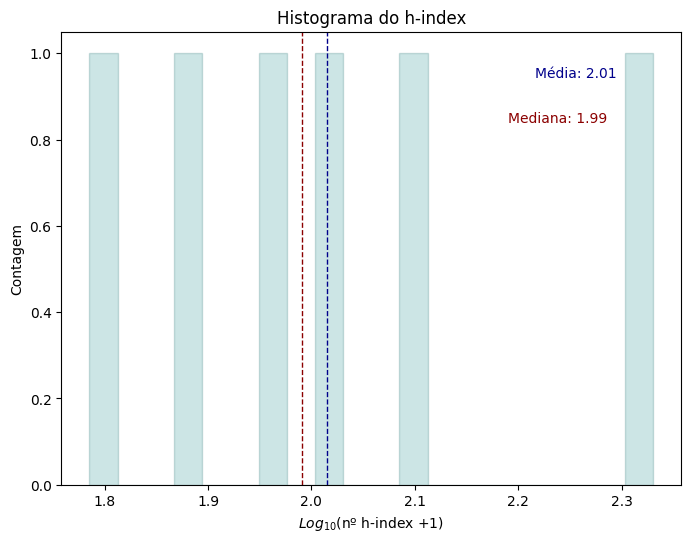

In [29]:
x=df.hindex.astype(int)

x=np.log10(x+1)
titulo='Histograma do h-index'
eixo_x='$Log_{10}$(nº h-index +1)'
eixo_y='Contagem'

histograma(x,20,eixo_x,eixo_y,titulo)
serie=pd.Series(x)
percentis =[.20, .40, .60, .80]
serie.describe(percentiles = percentis)

count    6.000000
mean     1.779416
std      0.165932
min      1.623249
20%      1.643453
40%      1.732394
50%      1.740291
60%      1.748188
80%      1.857332
max      2.071882
Name: hindex5y, dtype: float64

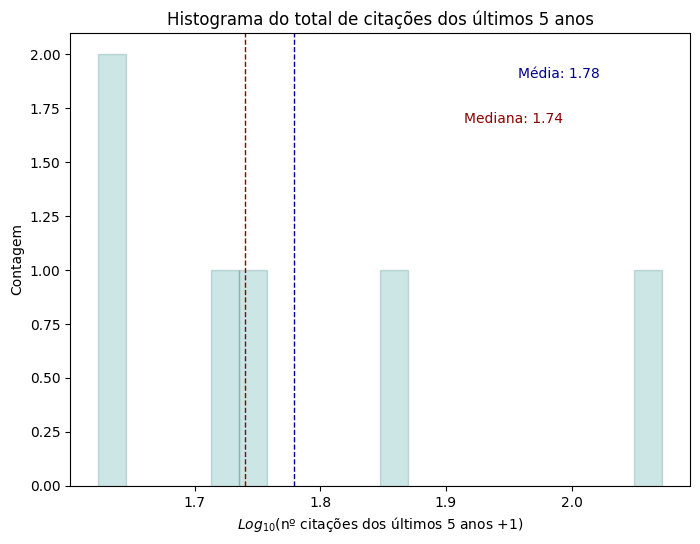

In [26]:
x=df.hindex5y.astype(int)

x=np.log10(x+1)
titulo='Histograma do h-index dos últimos 5 anos'
eixo_x='$Log_{10}$(nº h-index dos últimos 5 anos +1)'
eixo_y='Contagem'

histograma(x,20,eixo_x,eixo_y,titulo)
serie=pd.Series(x)
percentis =[.20, .40, .60, .80]
serie.describe(percentiles = percentis)

count    6.000000
mean     5.083680
std      0.310035
min      4.536584
20%      5.003822
40%      5.051384
50%      5.136957
60%      5.222529
80%      5.245934
max      5.441825
Name: citedby, dtype: float64

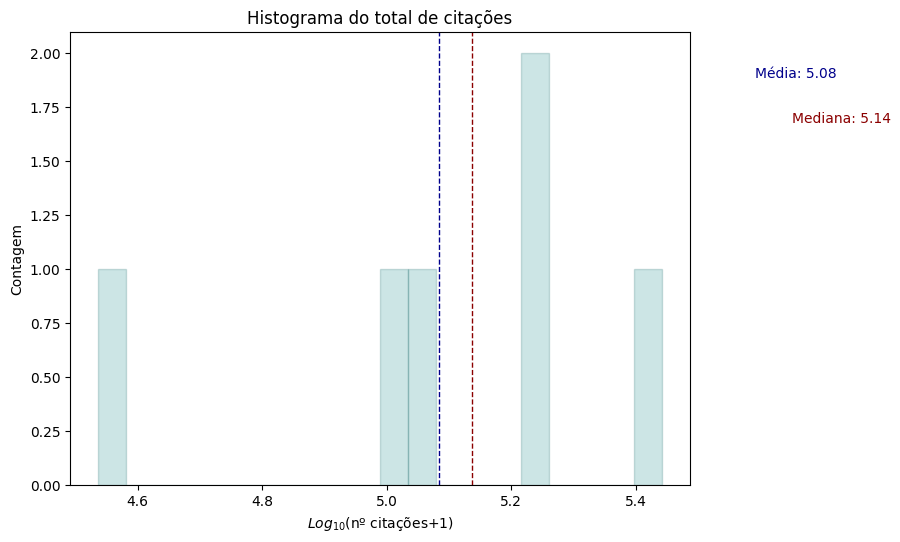

In [30]:
x=df.citedby.astype(int)

x=np.log10(x+1)
titulo='Histograma do total de citações'
eixo_x='$Log_{10}$(nº citações+1)'
eixo_y='Contagem'

histograma(x,20,eixo_x,eixo_y,titulo)
serie=pd.Series(x)
percentis =[.20, .40, .60, .80]
serie.describe(percentiles = percentis)

count    6.000000
mean     4.488247
std      0.355756
min      3.858297
20%      4.367915
40%      4.475177
50%      4.565695
60%      4.656213
80%      4.696872
max      4.875009
Name: citedby5y, dtype: float64

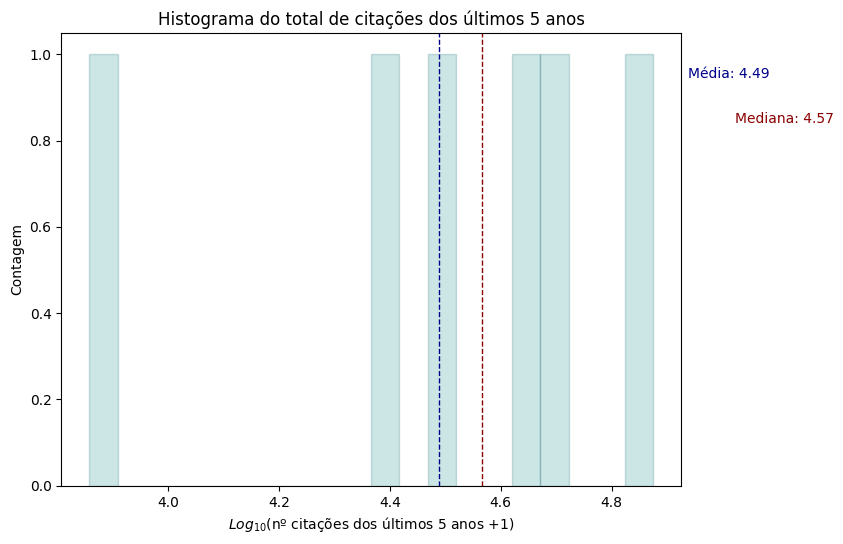

In [28]:
x=df.citedby.astype(int)

x=np.log10(x+1)
titulo='Histograma do total de citações dos últimos 5 anos'
eixo_x='$Log_{10}$(nº citações dos últimos 5 anos +1)'
eixo_y='Contagem'

histograma(x,20,eixo_x,eixo_y,titulo)
serie=pd.Series(x)
percentis =[.20, .40, .60, .80]
serie.describe(percentiles = percentis)

# Bibliografia

https://stackoverflow.com/questions/62917910/python-export-pandas-dataframe-to-google-sheets-solved

https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82#c6c5

ttps://medium.com/analytics-vidhya/embedding-your-image-in-google-colab-markdown-3998d5ac2684